# RPA Analysis Notebook

This notebook is used to analyze the automation potential of process steps

In [13]:
import pandas as pd

pd.options.mode.copy_on_write = True

In [14]:
# Data Upload
df = pd.read_csv("Insurance_claims_event_log.csv")
df['timestamp'] = pd.to_datetime(df['timestamp']) #The timestamp is converted to datetime type.

df = df.sort_values(['case_id', 'timestamp']) #Sorting is done with case_id and timestamp: This is to make it suitable for temporal analysis of processes.
df.head()

,case_id,timestamp,activity_name,user_type
0,1,2024-01-01 09:00:00,Start,system
1,1,2024-01-01 09:01:00,Assign Agent,agent
2,1,2024-01-01 09:05:00,Check Document,agent
3,1,2024-01-01 09:07:00,Approve Claim,supervisor
4,2,2024-01-02 10:00:00,Start,system


In [15]:
# Calculate Step times
df = df.assign(
    next_timestamp = df.groupby('case_id')['timestamp'].shift(-1), #shift(-1) to get the time of the next step in the same case_id
    duration_sec = lambda d: (
        d['next_timestamp'] - d['timestamp']
    ).dt.total_seconds()
)
df['duration_sec'] = df['duration_sec'].fillna(30) #Since the last step has no next_timestamp, its duration is NaN. Therefore it is filled with a default time (e.g. 30 seconds).

In [16]:
# Detect manuel steps
#Steps with manual operation in the activity name are marked as manual steps (is_manual).
MANUAL_KEYWORDS = ["Assign", "Review", "Check", "Approve", "Validate", "Sign"]
df['is_manual'] = df['activity_name'].str.contains("|".join(MANUAL_KEYWORDS), case=False)

In [17]:
#user diversity and group statistics
step_stats = (
    df.groupby('activity_name') # for unique activity name
      .agg(avg_duration=('duration_sec', 'mean'),
           is_manual=('is_manual', 'any'),
           resource_diversity=('user_type', 'nunique')) #How many different types of users (user_type) are there (resource_diversity)?
      .reset_index()
)
step_stats.head()

,activity_name,avg_duration,is_manual,resource_diversity
0,Approve Claim,30.0,True,1
1,Assign Agent,210.0,True,1
2,Check Document,120.0,True,1
3,Review Application,120.0,True,1
4,Sign Contract,30.0,True,1


In [ ]:
#Calculation automation score
weights = dict(manual=2, long_duration=1, single_resource=1)

step_stats = step_stats.assign(
    automation_score = (
        step_stats['is_manual'] * weights['manual']
        + (step_stats['avg_duration'] > 30) * weights['long_duration']
        + (step_stats['resource_diversity'] == 1) * weights['single_resource']
    ),
    recommendation = lambda s: s['automation_score'].apply(
        lambda x: "Strong candidate for RPA" if x >= 3
        else "Consider partial automation" if x == 2
        else "No automation needed"
    )
)
step_stats

,activity_name,avg_duration,is_manual,resource_diversity,automation_score,recommendation
0,Approve Claim,30.0,True,1,3,💡 Strong candidate for RPA
1,Assign Agent,210.0,True,1,4,💡 Strong candidate for RPA
2,Check Document,120.0,True,1,4,💡 Strong candidate for RPA
3,Review Application,120.0,True,1,4,💡 Strong candidate for RPA
4,Sign Contract,30.0,True,1,3,💡 Strong candidate for RPA
5,Start,120.0,False,1,2,🧐 Consider partial automation


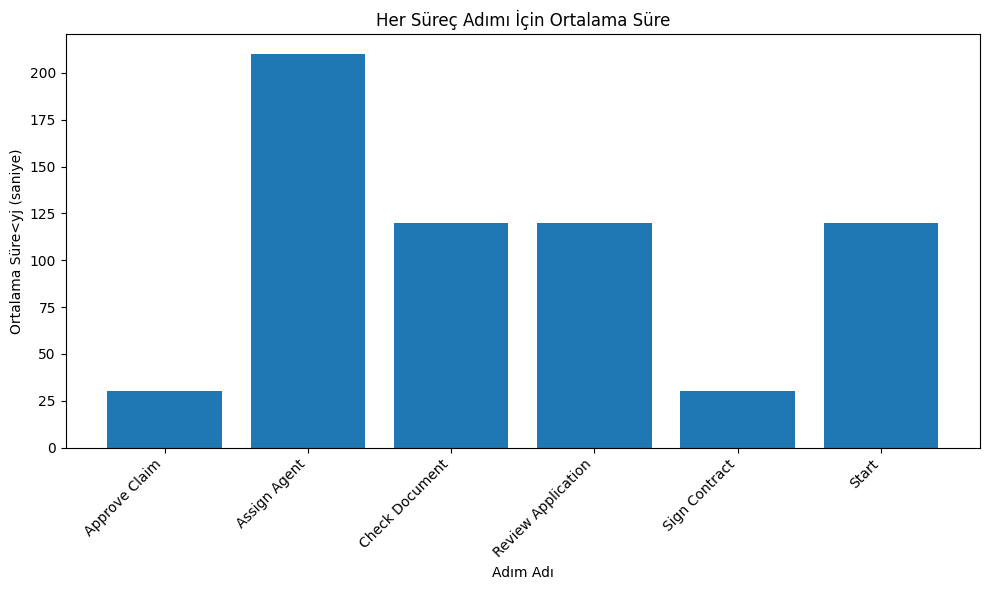

In [22]:
# Visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(step_stats['activity_name'], step_stats['avg_duration'])
ax.set_ylabel("Ortalama Süre<yj (saniye)")
ax.set_xlabel("Adım Adı")
ax.set_title("Her Süreç Adımı İçin Ortalama Süre")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()